# 1. Modeldiagnostiek 
-	Toets op normaliteit: Jarque-Bera test en Q-Q plot van residuen (quantile-quantile plot, ook wel normal probability plot genoemd).
-	Uitbijters (outlier detection): bijvoorbeeld door een plot van de residuen te maken, in het bijzonder een plot van residuals vs. leverage* en/of na te gaan welke waarden buiten de predictie-intervallen van het regressiemodel liggen (plot betrouwbaarheidsintervallen en predictie-intervallen).
-	Toets op seriecorrelatie: Breusch-Godfrey test.**
-	Toets op autocorrelatie: Durbin-Watson test.**
-	Toets op homo-/heteroskedasticiteit (wel of geen gelijke variantie***): Breusch-Pagan test, NCV test, plot residuals vs. fitted values en plot sqrt(standardized residuals) vs. fitted values.* 

* In R levert plot(LinMod) vier grafieken op. Linksboven staat de plot residuals vs. fitted values, linksonder de plot sqrt(standardized residuals) vs. fitted values. Rechtsboven staat de Q-Q plot van de residuen. Rechtsonder staat een plot van residuals vs. leverage, waarbij leverage een functie is van de regressoren. Zie ook https://data.library.virginia.edu/diagnostic-plots/. 
** De toetsen op seriecorrelatie en autocorrelatie hebben veel met elkaar te maken. Zie http://www.eviews.com/help/helpintro.html#page/content/timeser-Testing_for_Serial_Correlation.html
*** Zie https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/ en https://www.theanalysisfactor.com/linear-models-r-diagnosing-regression-model/

JB, DB zitten al in standaard modelsummary


In [117]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

Loading BokehJS ...

In [118]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

In [119]:
execute_notebook('../satellite/get-data.ipynb')

In [120]:
# laad eerste het model met de summary
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]
# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names, include_wind=False)

rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In [121]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'Stations of which the data is used: {", ".join(station_names)}')

Stations of which the data is used: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


In [122]:
# Add surge
# Load surge and convert from meters to mm
surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000
# Calculate average over given stations, per year
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)
# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

# Create a corrected dataframe by subtracting the surge
mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']   

# mean_df_corrected = mean_df_corrected[mean_df_corrected['year'] >= 1980]

In [123]:
# Linear fit
linear_fit, names = linear_model(mean_df_corrected, with_wind=False, with_season=False)

table = linear_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model corrected for surge (1980-current)'
)
display(table)


<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model corrected for surge (1980-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     322.9
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           4.08e-58
Time:                        13:40:37   Log-Likelihood:                -588.10
No. Observations:                 127   AIC:                             1184.
Df Residuals:                     123   BIC:                             1196.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.7182      2.471     -9.600      0.000     -28.609     -18.828
Trend          1.9091      0.061     31.115      0.000       1.788       2.031
Nodal U        5.1891      3.187      1.628      0.106      -1.120      11.498
Nodal V      -10.4890      3.162     -3.317      0.001     -16.749      -4.229
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.807
Skew:                          -0.280   Prob(JB):                        0.246
Kurtosis:                       3.465   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q-Q-plot of the residuals

The first check is for the normality of the residuals. To check this visually, we make a quantile-quantile plot of the theoretical quantiles (normal distribution) against the data quantiles (ranks).

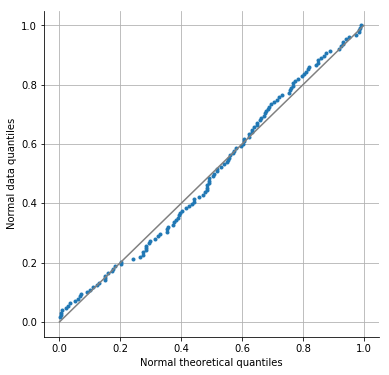

In [124]:
fig, ax = plt.subplots(figsize=(6, 6))
from scipy.stats import norm

# Calculate the exceedance probabilities given a normal distribution
cprob = norm.cdf(linear_fit.resid, loc=linear_fit.resid.mean(), scale=linear_fit.resid.std())
# Calculate the data quantiles: rank / (n + 1)
ranks = (linear_fit.resid.rank().values + 1) / (len(linear_fit.resid) + 1)

# Scatter
ax.plot(cprob, ranks, marker='.', ls='')
# Plot the 1-1 line
ax.plot([0, 1], [0, 1], ls='-', color='0.5')

# Layout
ax.grid()
ax.set_ylabel('Normal data quantiles')
ax.set_xlabel('Normal theoretical quantiles')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Breusch Godfrey


Lagrange multiplier test statistic: 24.424
P-value for Lagrange multiplier test: 0.018
Fstatistic for F test: 2.202
P-value for F test: 0.016



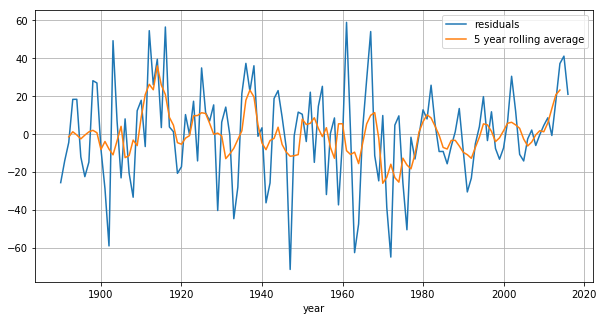

In [125]:
import pandas as pd
fig, ax = plt.subplots(figsize=(10, 5))

resid_df = pd.DataFrame(
    data=linear_fit.resid.values,
    index=mean_df_corrected.year,
    columns=['residuals']
)
resid_df['5 year rolling average'] = resid_df.rolling(window=5, center=True).mean()

resid_df.plot(ax=ax)

ax.grid()

import statsmodels

bg = statsmodels.stats.diagnostic.acorr_breusch_godfrey(linear_fit)

print("""
Lagrange multiplier test statistic: {:.3f}
P-value for Lagrange multiplier test: {:.3f}
Fstatistic for F test: {:.3f}
P-value for F test: {:.3f}
""".format(*bg))

### Heteroskedasticiteit

In [126]:
residuals = linear_fit.resid.values
statsmodels.stats.diagnostic.het_breuschpagan?
bp = statsmodels.stats.diagnostic.het_breuschpagan(resid_df[['residuals']].values, mean_df_corrected.values)

print("""
Lagrange multiplier test statistic: {:.3f}
P-value for Lagrange multiplier test: {:.3f}
Fstatistic for F test: {:.3f}
P-value for F test: {:.3f}
""".format(*bp))


Lagrange multiplier test statistic: 39.566
P-value for Lagrange multiplier test: 0.000
Fstatistic for F test: 18.704
P-value for F test: 0.000

